# Load Qick

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from qick_workspace.tools import system_cfg
from qick_workspace.tools.system_tool import select_config_idx
from qick import *
from qick.pyro import make_proxy
from qick import QickConfig
from qick.asm_v2 import QickSpan, QickSweep1D
import Pyro4

Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION = 4

ns_host = "192.168.10.63"
ns_port = 8887
proxy_name = "myqick"

soc, soccfg = make_proxy(ns_host=ns_host, ns_port=ns_port, proxy_name=proxy_name)
print(soccfg)

QICK library version mismatch: 0.2.375 remote (the board), 0.2.371 local (the PC)
                        This may cause errors, usually KeyError in QickConfig initialization.
                        If this happens, you must bring your versions in sync.


Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8887
myqick PYRO:obj_39534301ddc44d1196ef02f58505d828@192.168.10.63:8080
QICK running on ZCU216, software version 0.2.375

Firmware configuration (built Tue Sep 10 16:13:40 2024):

	Global clocks (MHz): tProc dispatcher timing 430.080, RF reference 245.760
	Groups of related clocks: [tProc timing clock, DAC tile 0, DAC tile 1, DAC tile 3], [DAC tile 2], [ADC tile 2]

	16 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 16384 complex samples (1.709 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 0 is 0_230 on JHC3, or QICK box DAC port 8
	1:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 4096 complex samples (0.427 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 2, blk 1 is 1_230 on JHC4, or QICK box DAC port 9
	2:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 8192 complex samples (0.855 us)
		32-bit DDS, range=9584.6

# Qubit setting

In [25]:
from qick_workspace.tools.system_tool import ExperimentConfig
from qick_workspace.tools.ncfg import config_list

qubit = "Q1"
config_all = ExperimentConfig(config_list)
run_cfg = config_all.get_qubit(qubit)

# TOF

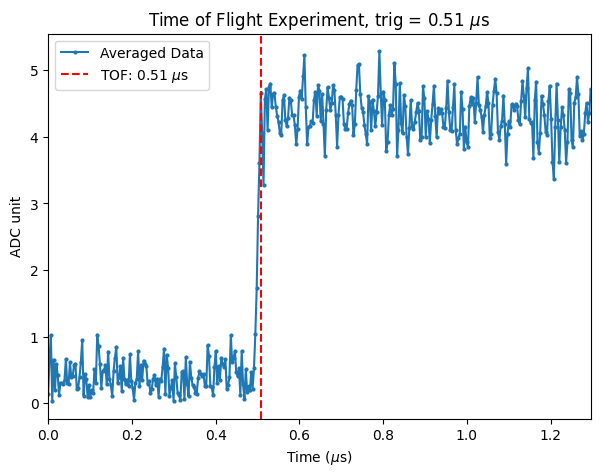

In [ ]:
from qick_workspace.scrip.s001_time_of_flight import TOF

run_cfg = config_all.get_qubit(qubit)
run_cfg.update(
    {
        "res_freq_ge": 6000,
        "ro_length": 1.3,
        "res_legnth": 0.2,
        "res_gain_ge": 1,
        "res_ch": 0,
    }
)

tof = TOF(soc, soccfg, run_cfg)
tof.run(100, liveplot=True)
# tof.plot()


# tof.saveLabber(qubit)

In [26]:
config_all.update("trig_time", 0.49, q_index=qubit)


# YOKO setting

In [4]:
from qick_workspace.tools.YOKOGS200 import YOKOGS200
import pyvisa

rm = pyvisa.ResourceManager()
yoko_connect = "USB0::0x0B21::0x0039::91WB18859::INSTR"
yoko = YOKOGS200(yoko_connect, rm)

yoko.OutputOn()
# yoko.OutputOff()

## Current mode

In [ ]:
yoko.SetMode("current")
yokocurrent = 0 * 1e-3
yoko.SetCurrent(yokocurrent)
yoko.GetCurrent()

Setting Current:   0%|          | 0/1 [00:00<?, ?it/s]

0.0

## Voltage mode

In [5]:
# yoko.SetMode("voltage")
# yoko_value = -12.6
# yoko.SetVoltage(yoko_value, _rampstep=1e-2)
# # yoko.GetVoltage()
# print(yoko.GetValue())
# yoko_value = yoko.GetValue()

# GE state

## Resonator OneTone

c:\Users\QEL\Desktop\SQC_soc\qick_workspace\tools\abcd_rf_fit\abcd_rf_fit.py:187: UserWarning: Extracted phi_0 greater than 0.25, this might indicate a big impedance mismatch, values of kappa_i and kappa_c might be affected, you can try to set: allow_mismatch=False
  warnings.warn("Extracted phi_0 greater than 0.25, this might indicate a big impedance mismatch, values of kappa_i and kappa_c might be affected, you can try to set: allow_mismatch=False", UserWarning)


{'Fres(GHz)': np.float64(5.349),
 'Qi': 10336,
 'Ql': 815,
 'absQc': 884,
 'κ(MHz)': np.float64(6.57)}


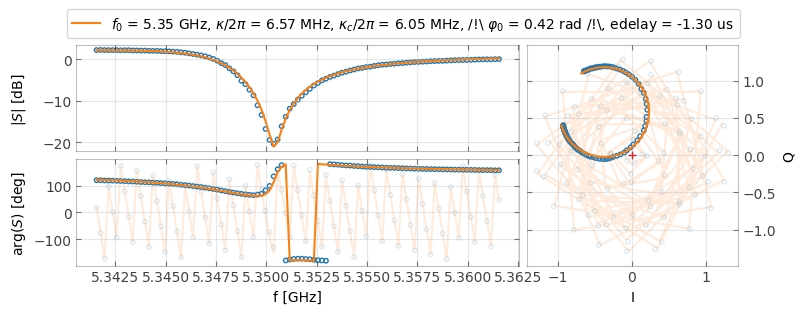

In [27]:
from qick_workspace.scrip.s002_res_spec_ge import Resonator_onetone


START_FREQ = config_all.get_qubit(qubit)["res_freq_ge"] - 10  # [MHz]
STOP_FREQ = config_all.get_qubit(qubit)["res_freq_ge"] + 10  # [MHz]
STEPS = 101


config_all.update("res.res_gain_ge", 0.2, q_index=qubit)
run_cfg = config_all.get_qubit(qubit)

run_cfg.update(
    [
        ("steps", STEPS),
        ("res_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("relax_delay", 1),
    ]
)

onetone = Resonator_onetone(soc, soccfg, run_cfg)
fres = onetone.run(py_avg=20, liveplot=True, solve_type="hm")
## update value ##
config_all.update("res.res_freq_ge", round(fres[0] / 1e6, 4), q_index=qubit)
# onetone.saveLabber(qubit, yoko_value=yoko_value)


## OneTone PunchOut

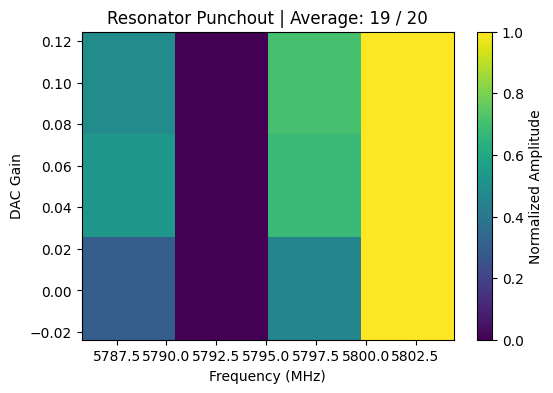

Software Average Count:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
from qick_workspace.scrip.s002b_res_punchout_ge import (
    SingleToneSpectroscopyPunchout,
)


START_FREQ = config_all.get_qubit(qubit)["res_freq_ge"] - 7  # [MHz]
STOP_FREQ = config_all.get_qubit(qubit)["res_freq_ge"] + 7  # [MHz]
STEPS_freq = 41

START_gain = 0.001  # [MHz]
STOP_gain = 0.1  # [MHz]
STEPS_gain = 21

run_cfg = config_all.get_qubit(qubit)
run_cfg.update(
    [
        ("f_steps", STEPS_freq),
        ("res_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("g_steps", STEPS_gain),
        ("res_gain_ge", QickSweep1D("gainloop", START_gain, STOP_gain)),
    ]
)
punchout = SingleToneSpectroscopyPunchout(soc, soccfg, run_cfg)
punchout.run(py_avg=50, liveplot=True)
# punchout.saveLabber(qubit)

## Onetone Flux

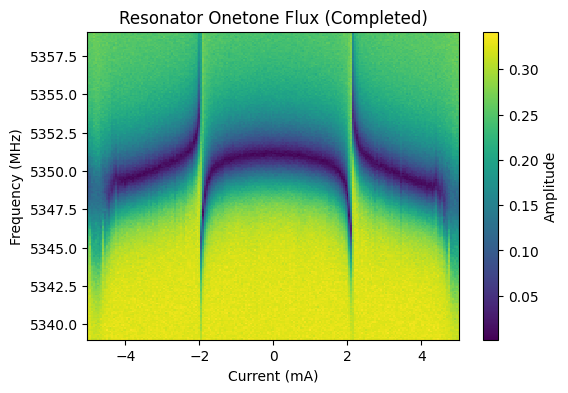

2025-11-27 16:38:36,811 - SR_Network:BlockingClient - Error: Socket operation timed out


Data save to C:\Users\QEL\Desktop\2DQ12round3\2025\11\Data_1127\s002_onetone_flux_QQ1_006


In [28]:
from qick_workspace.scrip.s002c_res_spec_ge_flux import (
    Resonator_onetone_flux,
)


START_FREQ = config_all.get_qubit(qubit)["res_freq_ge"] - 10  # [MHz]
STOP_FREQ = config_all.get_qubit(qubit)["res_freq_ge"] + 10  # [MHz]

STEPS = 201

Start_flux = -5
Stop_flux = 5
Steps_flux = 201
yoko_range = np.linspace(Start_flux, Stop_flux, Steps_flux) * 1e-3

run_cfg = config_all.get_qubit(qubit)
run_cfg.update(
    [
        ("steps", STEPS),
        ("res_gain_ge", 0.05),
        ("res_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("relax_delay", 1),
    ]
)

onetone_flux = Resonator_onetone_flux(soc, soccfg, run_cfg)
onetone_flux.run(
    5, liveplot=True, yoko_inst=yoko_connect, yoko_value=yoko_range, mode="current"
)
onetone_flux.saveLabber(qubit, yoko_range, mode="current")

In [19]:
yoko.SetCurrent(-2.3e-3)

Setting Current:   0%|          | 0/100 [00:00<?, ?it/s]

## Hardware loop

In [115]:
# from single_qubit_pyscrip_v1_1.s002c_res_spec_ge_flux import Resonator_onetone_flux

# run_cfg = select_config_idx(config, qubit_idx)

# START_FREQ = 5000
# STOP_FREQ = 6000
# STEPS = 101
# yoko_range = np.linspace(0, 1, 21)*1e-3
# run_cfg.update([('steps', STEPS),
#                 ('steps_flux', 21),
#                 ('flux_ch', 2),
#                 ('flux_length', 10),
#                 ('saturate_times', 0.5),
#                 ('res_freq_ge', QickSweep1D('freqloop', START_FREQ, STOP_FREQ)),
#                 ('flux_gain', QickSweep1D('fluxloop', -0.01, 0.01)),
#                 ('relax_delay', 1)
#                 ])

# onetone_flux = Resonator_onetone_flux(soc, soccfg, run_cfg)
# onetone_flux.liveplot_hardwre(50)

## Cooling sweep

In [28]:
# from single_qubit_pyscrip_v1_2.s002d_res_cooling_ge import SingleToneSpectroscopyCooling

# run_cfg = select_config_idx(config, qubit_idx)
# SPAN1 = 20
# cooling_freq = {}
# cooling_freq["f12"] = 6.303
# cooling_freq["f0g1"] = 1.290
# START_FREQ_1 = round(cooling_freq["f12"] * 1e3, 3) - SPAN1  # [MHz]
# STOP_FREQ_1 = round(cooling_freq["f12"] * 1e3, 3) + SPAN1  # [MHz]
# STEPS_freq_1 = 31

# SPAN2 = 20
# START_FREQ_2 = round(cooling_freq["f0g1"] * 1e3, 3) - SPAN2  # [MHz]
# STOP_FREQ_2 = round(cooling_freq["f0g1"] * 1e3, 3) + SPAN2  # [MHz]
# STEPS_freq_2 = 31

# config.update(
#     [
#         ("cool_ch1", 5),
#         ("cool_gain_1", 0.5),
#         ("nqz_cool_ch1", 2),
#         ("cool_mixer1", round(cooling_freq["f12"] * 1e3, 3)),
#         ("cool_ch2", 7),
#         ("cool_gain_2", 0.5),
#         ("nqz_cool_ch2", 2),
#         ("cool_mixer2", round(cooling_freq["f0g1"] * 1e3, 3)),
#         ("cool_length", 2),
#     ]
# )

# run_cfg.update(
#     [
#         ("f_steps1", STEPS_freq_1),
#         ("cool_freq_1", QickSweep1D("freqloop1", START_FREQ_1, STOP_FREQ_1)),
#         ("f_steps2", STEPS_freq_2),
#         ("cool_freq_2", QickSweep1D("freqloop2", START_FREQ_2, STOP_FREQ_2)),
#     ]
# )
# cooling = SingleToneSpectroscopyCooling(soc, soccfg, run_cfg)
# cooling.run(py_avg=30, liveplot=True)
# cooling.saveLabber(qubit_idx)

In [29]:
# config.update(
#     [
#         ("cool_ch1", 5),
#         ("cool_freq_1", 6309),
#         ("cool_gain_1", 0.5),
#         ("nqz_cool_ch1", 2),
#         ("cool_mixer1", 6309),
#         ("cool_ch2", 7),
#         ("cool_freq_2", 1278),
#         ("cool_gain_2", 0.5),
#         ("nqz_cool_ch2", 2),
#         ("cool_mixer2", 1278),
#         ("cool_length", 3),
#     ]
# )


## Qubit Spectrum ge

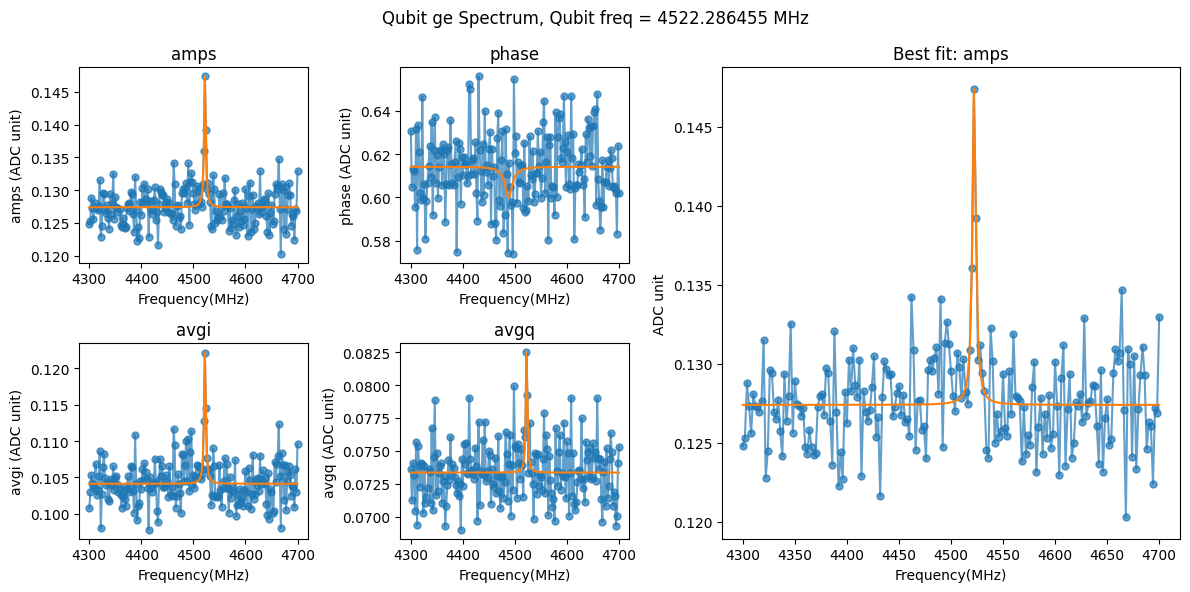

In [24]:
from qick_workspace.scrip.s003_qubit_spec_ge import Qubit_Twotone

center = 4500
SPAN = 200
START_FREQ = center - SPAN  # [MHz]
STOP_FREQ = center + SPAN  # [MHz]

STEPS = 201


run_cfg = config_all.get_qubit(qubit)
run_cfg.update(
    [
        ("steps", STEPS),
        ("qb_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("qmixer_freq", center),
        ("qbgain_ge", 0.5),
        ("qb_length_ge", 5),
        ("relax_delay", 1),
        ("nqz_qb", 2),
        ("qb_ch", 7),
    ]
)

spectrum_ge = Qubit_Twotone(soc, soccfg, run_cfg)
f_ge = spectrum_ge.run(20, liveplot=True)
config_all.update("qb.qb_freq_ge", f_ge, q_index=qubit)
config_all.update("qb.qb_mixer", f_ge, q_index=qubit)

# spectrum_ge.saveLabber(qubit, yoko_value=yoko_value)

### save

In [24]:
# import json

# FILENAME = "qubit_auto_test.json"
# # freq_report = {}


# def write_json_report(data_to_save):
#     output_data = {
#         "unit": {"current": "A", "frequency": "MHz"},
#         "qubit_freq_vs_current": data_to_save,
#     }

#     with open(FILENAME, "w") as f:
#         json.dump(output_data, f, indent=4)


# if os.path.exists(FILENAME):
#     try:
#         with open(FILENAME, "r") as f:
#             existing_data = json.load(f)
#             freq_report = existing_data.get("qubit_freq_vs_current", {})
#         print(f"Loaded existing data from {FILENAME}. Resuming sweep.")
#     except json.JSONDecodeEror:
#         print(f"Error reading existing JSON file. Starting new report.")

# print(f"--- Starting Qubit Two-tone Sweep, saving to {FILENAME} ---")
# yoko_value = yoko.GetValue()
# current_key = f"{yoko_value['value']:.4f} A"
# freq_report[current_key] = round(f_ge, 6)

# print(f"Current: {current_key}, Qubit Freq: {f_ge:.6f} MHz")

# write_json_report(freq_report)

## Qubit Spectrum ge Flux

KeyboardInterrupt: Interrupted at Yoko step: 17


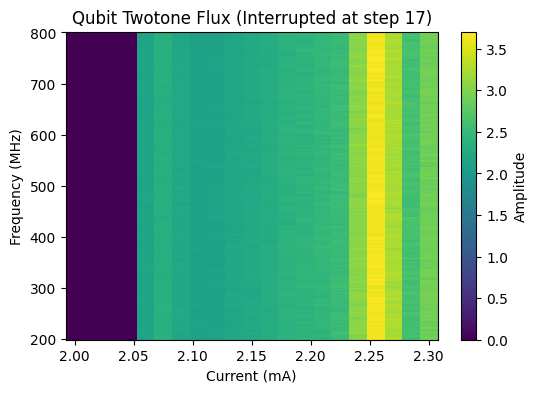

2025-11-18 11:36:08,368 - SR_Network:BlockingClient - Error: Socket operation timed out


Yoko sweep interrupted at step 17. Data stored.
Data save to C:\Users\QEL\Desktop\2DQ12round3\2025\11\Data_1118\003_qubit_flux_spec_ge_Q0_012


In [ ]:
from qick_workspace.scrip.s003a_qubit_flux_spec_ge import (
    Qubit_Twotone_Flux,
)

### qubit frequency scan range ###
center = 500
SPAN = 300
START_FREQ = center - SPAN  # [MHz]
STOP_FREQ = center + SPAN  # [MHz]
STEPS = 201
### qubit flux scan range ###
Start_flux = 2.3e-3
Stop_flux = 2e-3
Steps_flux = 21
yoko_range = np.linspace(Start_flux, Stop_flux, Steps_flux)


run_cfg = config_all.get_qubit(qubit)
run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_freq_ge", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("qmixe_freq", center),
        ("qubit_gain_ge", 1),
        ("qubit_length_ge", 6.0),
        ("relax_delay", 1),
        ("cooling", False),
        ("qubit_ch", 5),
    ]
)

spectrum_ge_flux = Qubit_Twotone_Flux(soc, soccfg, run_cfg)
spectrum_ge_flux.run(
    50, liveplot=True, yoko_inst=yoko_connect, yoko_value=yoko_range, mode="current"
)
spectrum_ge_flux.saveLabber(qubit_idx, yoko_range, mode="current")

## Length Rabi ge

Scan interrupted at average: 2


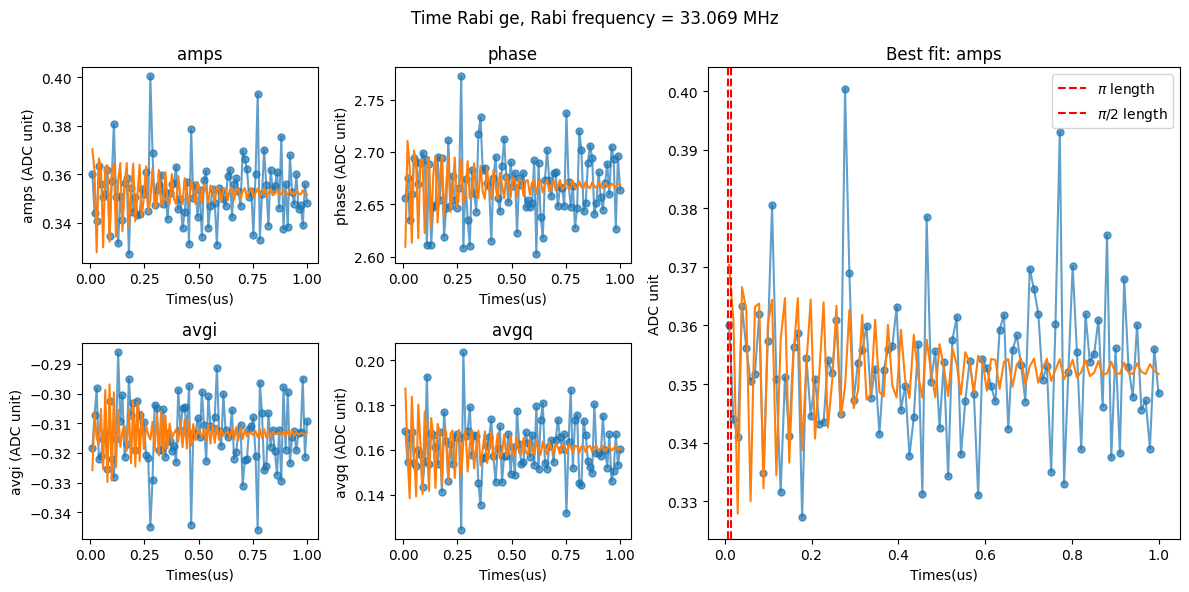

In [7]:
from qick_workspace.scrip.s004_time_rabi_ge import Time_Rabi

time_array = np.linspace(0.01, 1, 101)


config_all.update("qb.sigma", 0.05, q_index=qubit)
config_all.update("relax_delay", 30, q_index=qubit)

run_cfg = config_all.get_qubit(qubit)
run_cfg.update(
    [
        ("cooling", False),
        ("qbv_gain_ge", 0.5),
    ]
)

Trabi = Time_Rabi(soc, soccfg, run_cfg)
a, b = Trabi.run(20, liveplot=True, time_axis=time_array)
# Trabi.saveLabber(qubit, yoko_value=yoko_value)

## Power Rabi ge

Experiment interrupted at 6 averages. Fit is based on partial data.


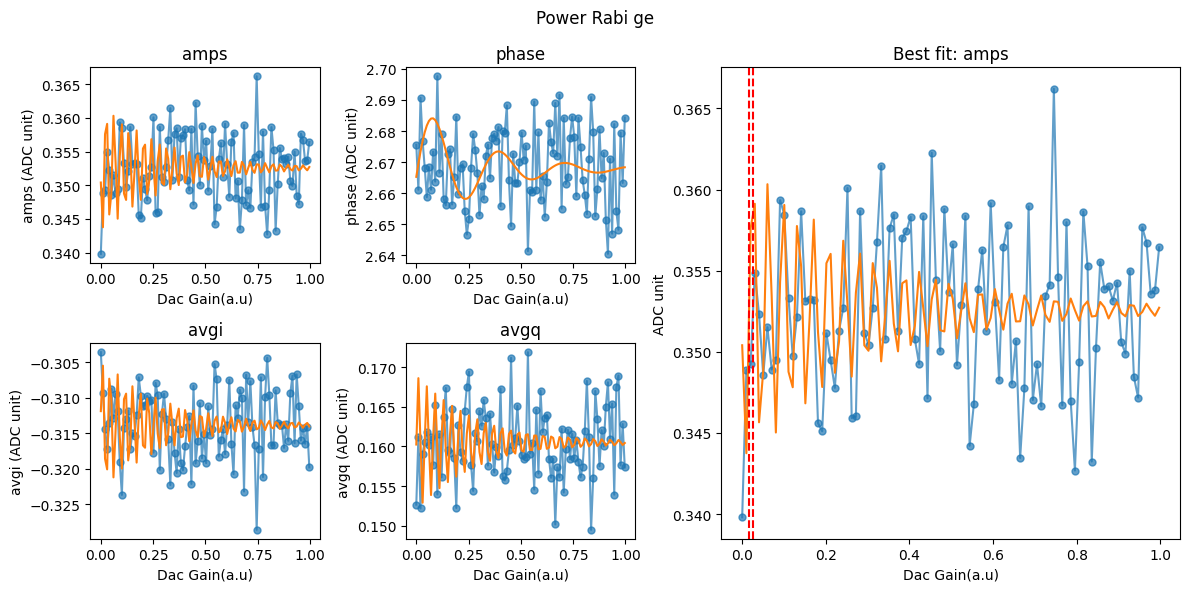

In [8]:
from qick_workspace.scrip.s005_power_rabi_ge import Amp_Rabi


START_GAIN = 0.0  # [DAC units]
STOP_GAIN = 1  # [DAC units]
STEPS = 100

config_all.update("qb.sigma", 0.05, q_index=qubit)
config_all.update("relax_delay", 30, q_index=qubit)
run_cfg = config_all.get_qubit(qubit)

run_cfg.update(
    [
        ("steps", STEPS),
        ("qb_gain_ge", QickSweep1D("gainloop", START_GAIN, STOP_GAIN)),
        ("cooling", False),
        ("qb_ch", 7),
    ]
)

prabi = Amp_Rabi(soc, soccfg, run_cfg)
pi_gain, pi2_gain = prabi.run(20, liveplot=True)
config_all.update("qb.pi_gain", pi_gain, q_index=qubit)
config_all.update("qb.pi2_gain", pi_gain, q_index=qubit)
# prabi.saveLabber(qubit, yoko_value=yoko_value)

## Ramsey

Experiment interrupted at 4 averages. Fit is based on partial data.


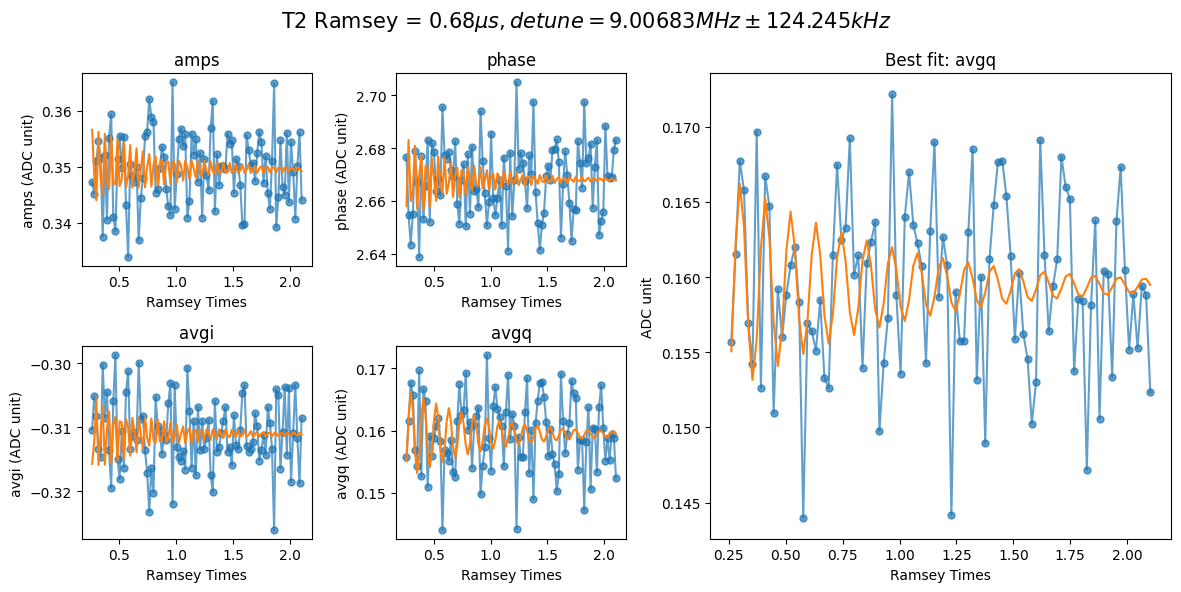

In [9]:
from qick_workspace.scrip.s006_Ramsey_ge import Ramsey

run_cfg = config_all.get_qubit(qubit)

START_TIME = 0.0  # [us]
STOP_TIME = 2  # [us]
STEPS = 100
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("ramsey_freq", 2),
    ]
)

t2r = Ramsey(soc, soccfg, run_cfg)
t2r.run(20, liveplot=True)
# t2r.saveLabber(qubit_idx, yoko_value=yoko_value)


In [41]:
config_all.update("qb.qb_freq_ge", t2r.correct_detune(), qubit)

over detune -0.01876MHz


## Echo

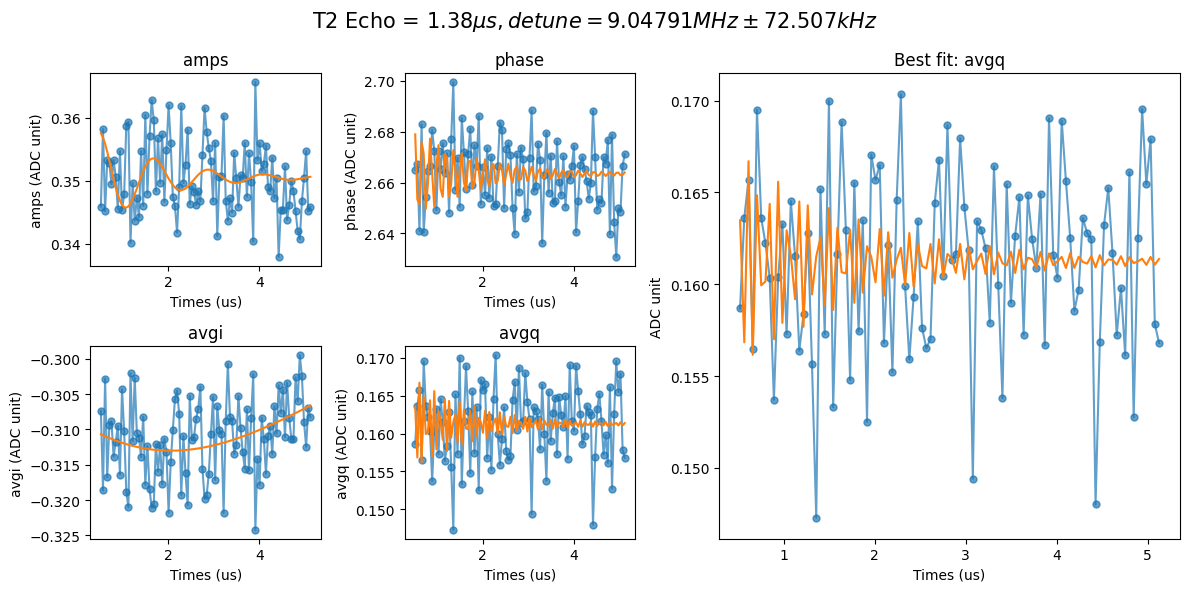

In [10]:
from qick_workspace.scrip.s007_SpinEcho_ge import SpinEcho

run_cfg = config_all.get_qubit(qubit)

START_TIME = 0.0  # [us]
STOP_TIME = 5  # [us]
STEPS = 100
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("ramsey_freq", 1),
        ("cooling", False),
        ("qubit_ch", 5),
    ]
)

t2e = SpinEcho(soc, soccfg, run_cfg)
t2e.run(20, liveplot=True)

# t2e.saveLabber(qubit_idx, yoko_value=yoko_value)

## T1

Traceback (most recent call last):
  File "c:\Users\QEL\Anaconda3\envs\qick2env\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\QEL\AppData\Local\Temp\ipykernel_33680\2075749420.py", line 20, in <module>
    t1.saveLabber(qubit, yoko_value=yoko_value)
NameError: name 'yoko_value' is not defined


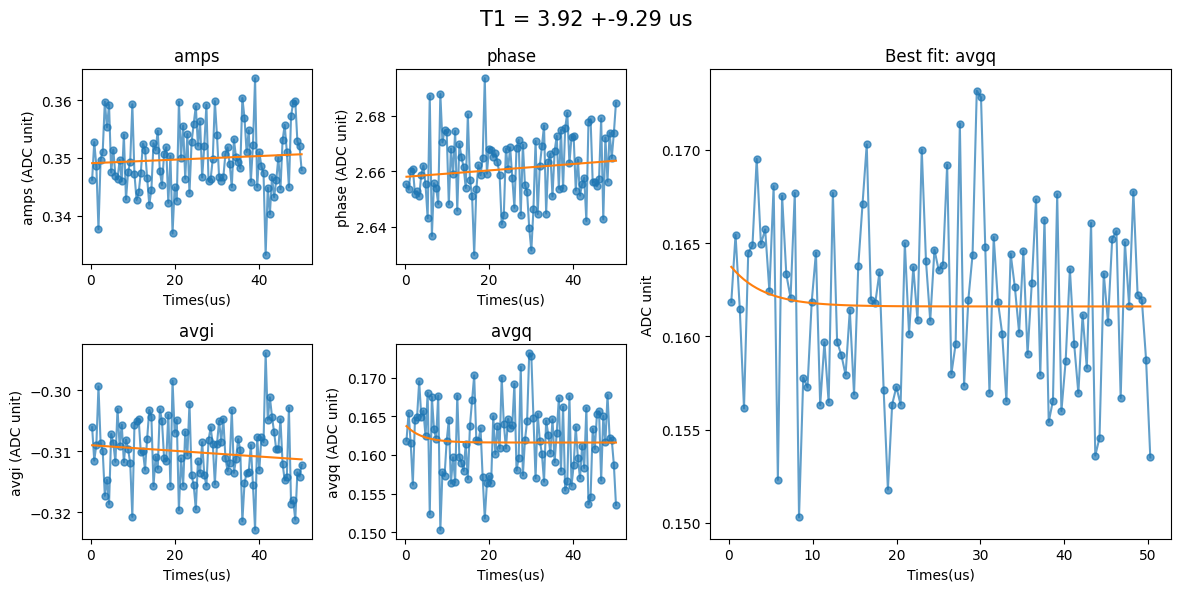

In [11]:
from qick_workspace.scrip.s008_T1_ge import T1

run_cfg = config_all.get_qubit(qubit)

START_TIME = 0.0  # [us]
STOP_TIME = 50  # [us]
STEPS = 100
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("relax_delay", 50),
        ("cooling", False),
        ("qubit_ch", 5),
    ]
)

t1 = T1(soc, soccfg, run_cfg)
t1.run(50, liveplot=True)
# t1.saveLabber(qubit, yoko_value=yoko_value)

## Single shot

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

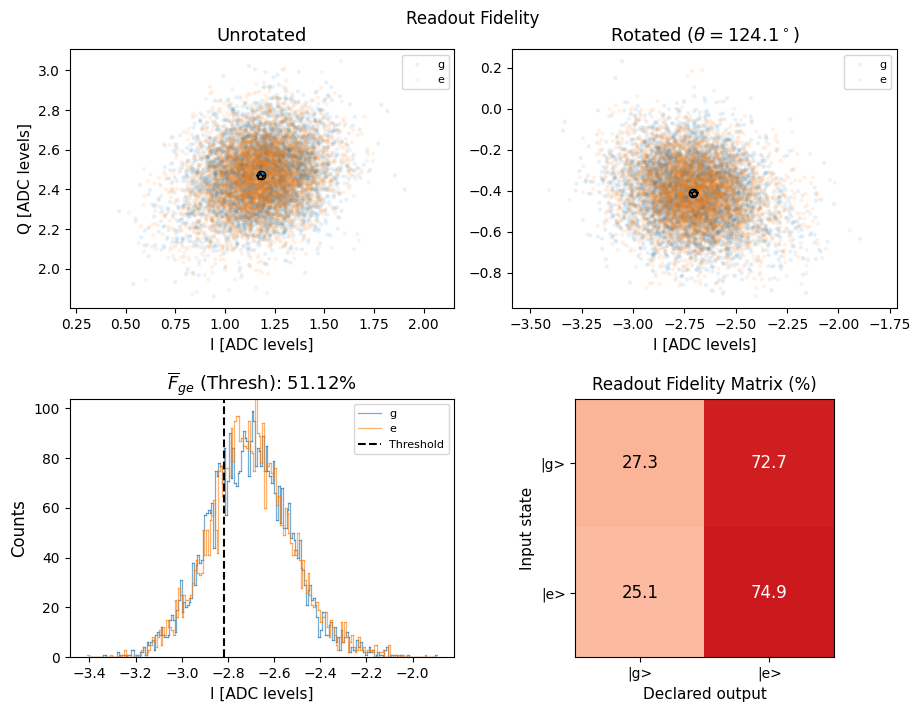

Theta: 124.14 deg
Threshold Fidelity: 51.120%
Fidelity Matrix (%):
 [[27.34 72.66]
 [25.1  74.9 ]]


[[np.float64(0.5112000000000001)],
 [np.float64(-2.8190652040588002)],
 np.float64(124.13584841808506)]

In [69]:
from qick_workspace.scrip.s000_SingleShot_prog import SingleShot_gef

run_cfg = config_all.get_qubit(qubit)

run_cfg["ro_length"] = 2
run_cfg["res_gain_ge"] = 0.8


SHOT = 5000
ssh = SingleShot_gef(soc, soccfg, run_cfg)
ssh.run(SHOT, shot_f=False)
ssh.plot(fid_avg=True, verbose=True, fit=False)


### Single Shot optimize

In [63]:
from qick_workspace.scrip.s000_SingleShot_ge_prog_opt import (
    SingleShot_ge_opt,
)

run_cfg = config_all.get_qubit(qubit)
SHOT = 1


freq_axis = np.linspace(run_cfg["res_freq_ge"] - 1, run_cfg["res_freq_ge"] + 1, 6)
gain_axis = np.linspace(0.1, 0.3, 3)
length_axis = np.linspace(0.2, 1.5, 3)
sweep_para = {"freq": run_cfg["res_freq_ge"], "gain": gain_axis, "length": length_axis}


ssh = SingleShot_ge_opt(soc, soccfg, run_cfg)
ssh.run(SHOT, sweep_para)
ssh.analyze()

Length loop:   0%|          | 0/3 [00:00<?, ?it/s]

Gain loop:   0%|          | 0/3 [00:00<?, ?it/s]

Gain loop:   0%|          | 0/3 [00:00<?, ?it/s]

Gain loop:   0%|          | 0/3 [00:00<?, ?it/s]

Analyze max fidelity:   0%|          | 0/3 [00:00<?, ?it/s]


--- Grid Search Result ---
Max fidelity (on grid): 1.0000
At length=0.200 us, gain=0.10000 DAC, freq=5351.55900 MHz

--- Interpolated Result ---
Max fidelity (interpolated): 1.0000
At length=0.200 us, gain=0.10000 DAC, freq=5351.55900 MHz


(np.float64(0.2), np.float64(0.1), 5351.559)

# EF state (Not repaired yet)

## Cooling to e

In [ ]:
from single_qubit_pyscrip_v1_1.s002d_res_cooling_ge import SingleToneSpectroscopyCooling

run_cfg = select_config_idx(config, qubit_idx)

START_FREQ_1 = 3150  # [MHz]
STOP_FREQ_1 = 3300  # [MHz]
STEPS_freq_1 = 51

START_FREQ_2 = 1900  # [MHz]
STOP_FREQ_2 = 2050  # [MHz]
STEPS_freq_2 = 51

config.update(
    [
        ("cool_ch1", 5),
        ("cool_gain_1", 0.8),
        ("nqz_cool_ch1", 2),
        ("cool_mixer1", 3000),
        ("cool_ch2", 2),
        ("cool_gain_2", 0.4),
        ("nqz_cool_ch2", 2),
        ("cool_mixer2", 2000),
        ("cool_length", 1),
    ]
)

run_cfg.update(
    [
        ("f_steps1", STEPS_freq_1),
        ("cool_freq_1", QickSweep1D("freqloop1", START_FREQ_1, STOP_FREQ_1)),
        ("f_steps2", STEPS_freq_2),
        ("cool_freq_2", QickSweep1D("freqloop2", START_FREQ_2, STOP_FREQ_2)),
    ]
)
cooling = SingleToneSpectroscopyCooling(soc, soccfg, run_cfg)
cooling.run(py_avg=20, liveplot=True)
# cooling.saveLabber(qubit_idx)

KeyboardInterrupt: 

## Onetone EF

c:\Users\QEL\Desktop\tprocv2_guidemo-2DQ12\single_qubit_pyscrip_v1_1\abcd_rf_fit\abcd_rf_fit.py:187: UserWarning: Extracted phi_0 greater than 0.25, this might indicate a big impedance mismatch, values of kappa_i and kappa_c might be affected, you can try to set: allow_mismatch=False
  warnings.warn("Extracted phi_0 greater than 0.25, this might indicate a big impedance mismatch, values of kappa_i and kappa_c might be affected, you can try to set: allow_mismatch=False", UserWarning)


{'Fres(GHz)': 7.5215, 'Qi': 27, 'Ql': 1956, 'absQc': -28, 'κ(MHz)': 3.85}


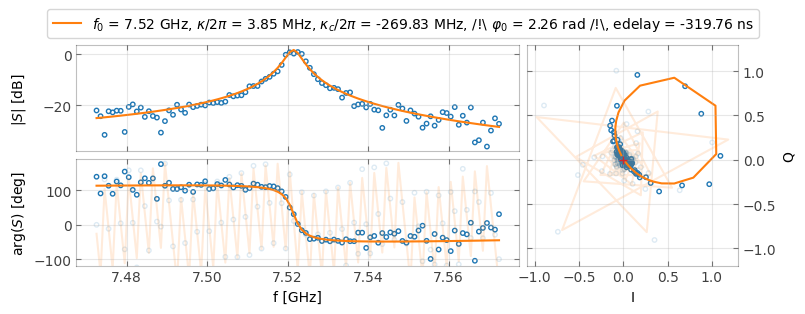

In [ ]:
from single_qubit_pyscrip_v1_1.s009_res_spec_ef import Resonator_onetone_ef


run_cfg = select_config_idx(config, qubit_idx)

START_FREQ = config["res_freq_ge"][qubit_idx] - 50  # [MHz]
STOP_FREQ = config["res_freq_ge"][qubit_idx] + 50  # [MHz]
STEPS = 101
run_cfg.update(
    [
        ("steps", STEPS),
        ("res_freq_ef", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("res_gain_ef", 0.2),
        ("cooling", False),
    ]
)

onetone_ef = Resonator_onetone_ef(soc, soccfg, run_cfg)
# onetone.run(py_avg=10)
fres = onetone_ef.run(py_avg=10, liveplot=True)
# result = onetone.plot_circle()
## update value ##
config["res_freq_ef"][qubit_idx] = round(fres[0] / 1e6, 4)
# config['res_freq_ef'][qubit_idx] = config['res_freq_ge'][qubit_idx]
# onetone_ef.saveLabber(qubit_idx, save_sim=True)|

## Qubit Spectrum ef

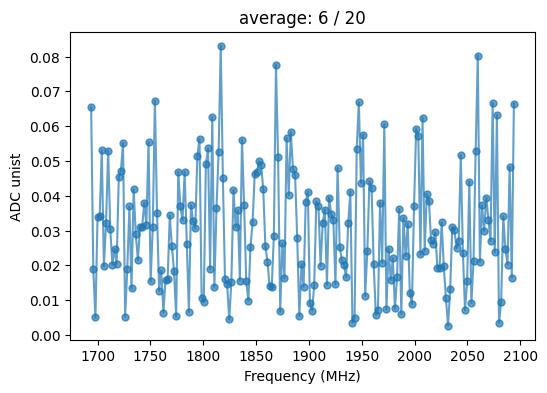

KeyboardInterrupt: 

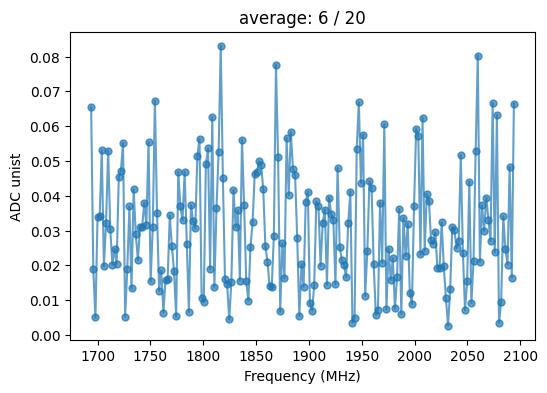

In [ ]:
from single_qubit_pyscrip_v1_1.s010_qubit_spec_ef import Qubit_Twotone_ef

run_cfg = select_config_idx(config, qubit_idx)

cemter = 1894
SPAN = 200
START_FREQ = cemter - SPAN  # [MHz]
STOP_FREQ = cemter + SPAN  # [MHz]
STEPS = 200

config["qubit_ch_ef"][qubit_idx] = 2


config.update(
    [
        ("nqz_qubit_ef", 2),
    ]
)
run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_freq_ef", QickSweep1D("freqloop", START_FREQ, STOP_FREQ)),
        ("qmixer_freq_ef", 2200),
        ("qubit_gain_ef", 0.2),
        ("nqz_qubit_ef", 2),
        ("relax_delay", 50),
        ("cooling", False),
        ("ge_ref", True),
    ]
)

spectrum_ge = Qubit_Twotone_ef(soc, soccfg, run_cfg)
f_ef = spectrum_ge.run(20, liveplot=True)
config["qubit_freq_ef"][qubit_idx] = f_ef
config["qmixer_freq_ef"][qubit_idx] = f_ef
spectrum_ge.saveLabber(qubit_idx, save_sim=True)

## Rabi EF

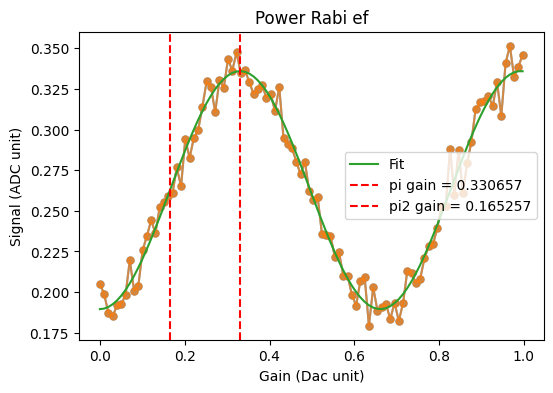

In [ ]:
from single_qubit_pyscrip_v1_1.s011_power_rabi_ef import Amp_Rabi_ef


START_GAIN = 0.0  # [DAC units]
STOP_GAIN = 1  # [DAC units]
STEPS = 100


config["sigma_ef"][qubit_idx] = 0.02
config["relax_delay"] = 50
run_cfg = select_config_idx(config, qubit_idx)

run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_gain_ef", QickSweep1D("gainloop", START_GAIN, STOP_GAIN)),
        ("cooling", False),
        ("ge_ref", True),
    ]
)

prabi = Amp_Rabi_ef(soc, soccfg, run_cfg)
config["qubit_pi_gain_ef"][qubit_idx], config["qubit_pi2_gain_ef"][qubit_idx] = (
    prabi.run(50, liveplot=True)
)
# a, b = prabi.run(50, liveplot=True)
# config['qubit_pi_gain_ge'][qubit_idx], config['qubit_pi2_gain_ge'][qubit_idx] = prabi.plot()
# prabi.saveLabber(qubit_idx)

## Ramsey ef

over detune 0.02285MHz


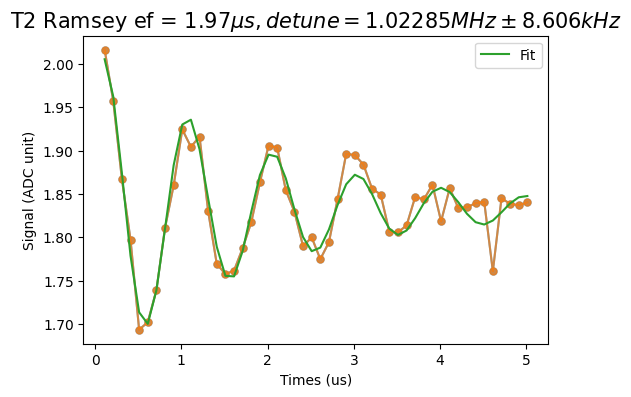

In [ ]:
from single_qubit_pyscrip_v1_1.s012_Ramsey_ef import Ramsey_ef

run_cfg = select_config_idx(config, qubit_idx)

START_TIME = 0.0  # [us]
STOP_TIME = 5  # [us]
STEPS = 50
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("ramsey_freq", 1),
        ("cooling", False),
        ("ge_ref", True),
    ]
)

t2r_ef = Ramsey_ef(soc, soccfg, run_cfg)
t2r_ef.run(20, liveplot=True)
# tt2r_ef2r.plot()
config["qubit_freq_ef"][qubit_idx] = t2r_ef.correct_detune()
# t2r_ef.saveLabber(qubit_idx, 0, save_sim=True)


## T1 ef

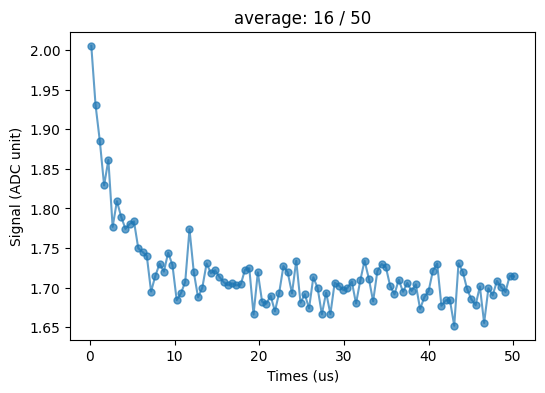

KeyboardInterrupt: 

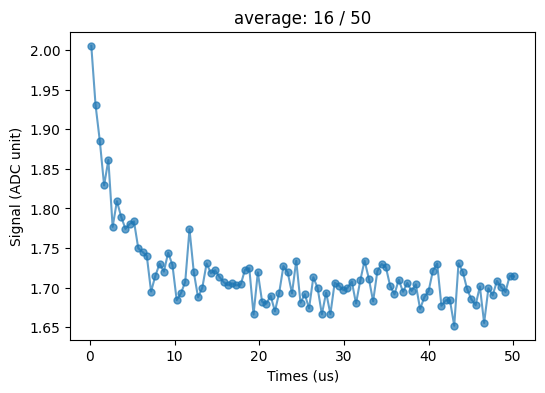

In [ ]:
from single_qubit_pyscrip_v1_1.s013_T1_ef import T1_ef

run_cfg = select_config_idx(config, qubit_idx)

START_TIME = 0.0  # [us]
STOP_TIME = 50  # [us]
STEPS = 100
run_cfg.update(
    [
        ("steps", STEPS),
        ("wait_time", QickSweep1D("waitloop", START_TIME, STOP_TIME)),
        ("relax_delay", 100),
        ("cooling", False),
        ("ge_ref", True),
    ]
)

t1_ef = T1_ef(soc, soccfg, run_cfg)
t1_ef.run(50, liveplot=True)


# t1.saveLabber(qubit_idx, 0, save_sim=True)

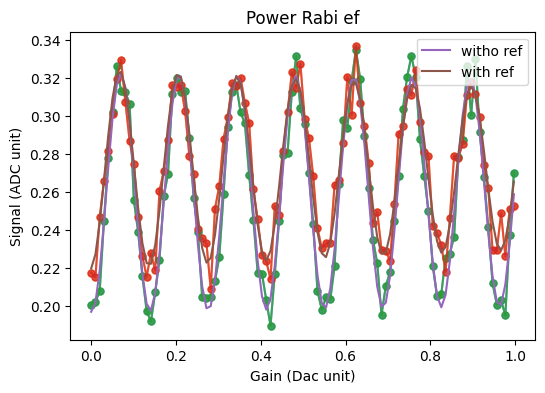

In [ ]:
from single_qubit_pyscrip_v1_1.s013_qubit_temp import Qubit_temperature


START_GAIN = 0.0  # [DAC units]
STOP_GAIN = 1  # [DAC units]
STEPS = 100


config["sigma_ef"][qubit_idx] = 0.1
config["relax_delay"] = 100
run_cfg = select_config_idx(config, qubit_idx)

run_cfg.update(
    [
        ("steps", STEPS),
        ("qubit_gain_ef", QickSweep1D("gainloop", START_GAIN, STOP_GAIN)),
        ("cooling", False),
        ("ge_ref", True),
    ]
)

prabi = Qubit_temperature(soc, soccfg, run_cfg)
# config['qubit_pi_gain_ef'][qubit_idx], config['qubit_pi2_gain_ef'][qubit_idx] = prabi.run(50, liveplot=True)
x, y = prabi.run(50, liveplot=True)
# config['qubit_pi_gain_ge'][qubit_idx], config['qubit_pi2_gain_ge'][qubit_idx] = prabi.plot()
# prabi.saveLabber(qubit_idx)

# ALLXY

  0%|          | 0/21 [00:00<?, ?it/s]

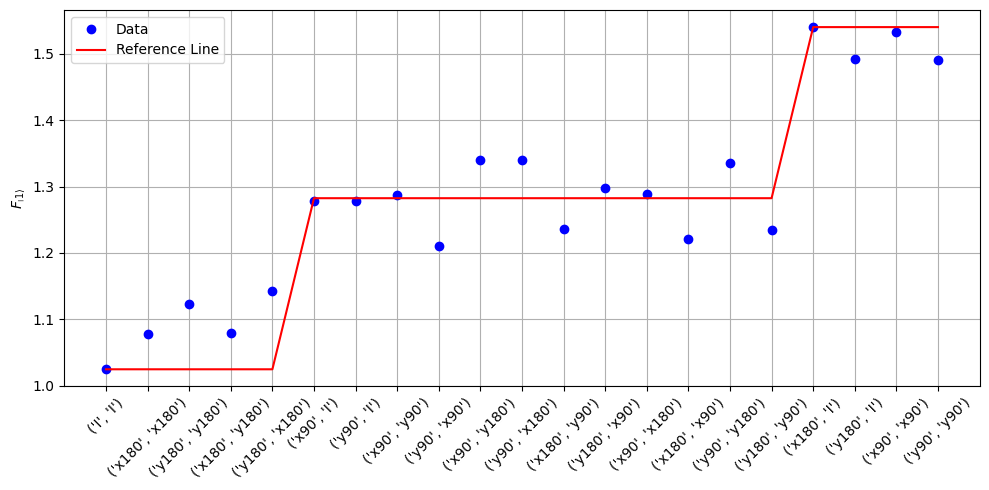

In [ ]:
from qick_workspace.scrip.s014_AllXY import AllXY

run_cfg = config_all.get_qubit(qubit)

allxy = AllXY(soc, soccfg, run_cfg)
allxy.run(10)
allxy.plot()

# State Tomography

Calibrating |0> state...
Calibrating |1> state...
IQ Ground (|0>): (0.4754134114583334+0.8862805989583332j)
IQ Excited (|1>): (0.8103131510416667+1.190084635416667j)
Running tomography for state prepared by: x180


Tomography (State: x180):   0%|          | 0/3 [00:00<?, ?it/s]

Raw Tomography IQ data: {'X': np.complex128(0.6913346354166666+1.1142539062499999j), 'Y': np.complex128(0.6610774739583333+1.0636119791666665j), 'Z': np.complex128(0.77211328125+1.184587890625j)}

Measured Expectation Values:
  <X> = -0.3849
  <Y> = -0.1352
  <Z> = -0.8585

--- Raw Density Matrix (before MLE) ---
[[ 0.07073967+0.j         -0.19243286+0.06762119j]
 [-0.19243286-0.06762119j  0.92926033+0.j        ]]

--- Final MLE Reconstructed Density Matrix ---
[[ 0.07073967+0.00000000e+00j -0.19243286+6.76211860e-02j]
 [-0.19243286-6.76211860e-02j  0.92926033+5.55111512e-17j]]

Purity: 0.95173 (1.0 = pure state)


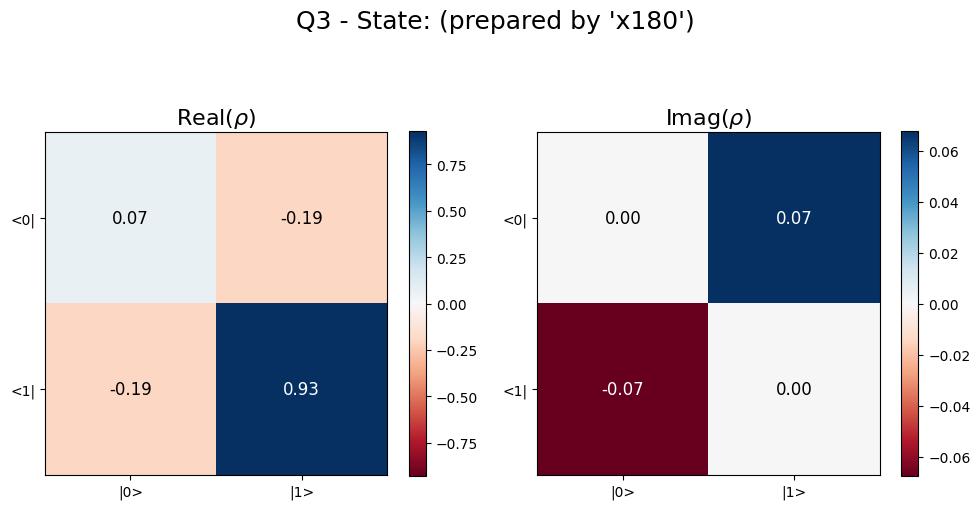

c:\Users\QEL\Desktop\SQC_soc_v2\qick_workspace\scrip\s016_state_tomography.py:509: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


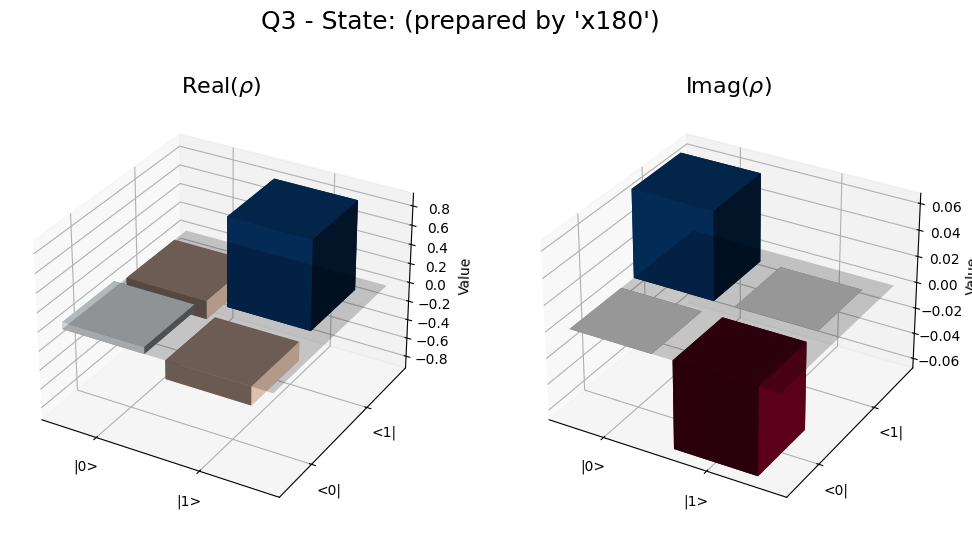

(<Figure size 1200x600 with 2 Axes>,
 (<Axes3D: title={'center': 'Real($\\rho$)'}, zlabel='Value'>,
  <Axes3D: title={'center': 'Imag($\\rho$)'}, zlabel='Value'>))

In [57]:
from qick_workspace.scrip.s016_state_tomography import Tomography

pyavg = 10


run_cfg = config_all.get_qubit(qubit)

tomo = Tomography(soc, soccfg, run_cfg)

tomo.run(py_avg=pyavg, prep_pulse_name="x180")

tomo.plot(plot_type="2d", qb_idx=3)
tomo.plot(plot_type="3d", qb_idx=3)

# Randomized Benchmarking

In [58]:
from qick_workspace.scrip.s015_Single_qubit_RB import (
    RandomizedBenchmarking,
)

run_cfg = config_all.get_qubit(qubit)


py_avg = 1
max_circuit_depth = 100
delta_clifford = 5
number_sample = 10


all_rb_results = []


print("\n--- Running Standard RB (Ref) ---")
rb_exp_ref = RandomizedBenchmarking(soc, soccfg, run_cfg)
rb_exp_ref.run(
    py_avg=py_avg,
    max_circuit_depth=max_circuit_depth,
    delta_clifford=delta_clifford,
    number_sample=number_sample,
    interleaved_gate=None,
)
rb_exp_ref.plot(label="Ref")

all_rb_results.append(rb_exp_ref)


--- Running Standard RB (Ref) ---


Standard RB depth:   0%|          | 0/20 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

Number of samples:   0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Interleve RB

In [ ]:
# interleaved_gates_to_test = ["X", "X/2", "-X/2", "Y", "Y/2", "-Y/2"]
interleaved_gates_to_test = ["X", "X/2", "Y", "Y/2"]

for gate in interleaved_gates_to_test:
    print(f"\n--- Running Interleaved RB ({gate}) ---")
    rb_exp_irb = RandomizedBenchmarking(soc, soccfg, run_cfg)
    rb_exp_irb.run(
        py_avg=py_avg,
        max_circuit_depth=max_circuit_depth,
        delta_clifford=delta_clifford,
        number_sample=number_sample,
        interleaved_gate=gate,
    )
    all_rb_results.append(rb_exp_irb)